In [1]:
import numpy as np
import pandas as pd
from math import log, exp
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.ensemble import *
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def FeatureEngineering(df):
    df['l1'] = np.nan
    df['l2'] = np.nan
    for i in range(len(df['penalty'])):
        if df['penalty'][i] == 'l1':
            df.at[i, 'l1'] = df.at[i, 'alpha']*df.at[i, 'l1_ratio']
            df.at[i, 'l2'] = 0
        elif df['penalty'][i] == 'l2':
            df.at[i, 'l1'] = 0
            df.at[i, 'l2'] = df.at[i, 'alpha']*(1-df.at[i, 'l1_ratio'])
        elif df['penalty'][i] == 'elasticnet':
            df.at[i, 'l1'] = df.at[i, 'alpha']*df.at[i, 'l1_ratio']
            df.at[i, 'l2'] = df.at[i, 'alpha']*(1-df.at[i, 'l1_ratio'])
        else:
            df.at[i, 'l1'] = 0
            df.at[i, 'l2'] = 0  

        df['n_jobs'] = df['n_jobs'].mask(df['n_jobs'] == -1, 16)
        df['log_sfm'] = np.log((df.n_samples)*(df.n_features)*(df.max_iter))
        df['log_sf'] = np.log((df.n_samples)*(df.n_features))
        df['log_total_cluster'] = np.log((df.n_classes)*(df.n_clusters_per_class)*(df.max_iter))
        df["scfmaxn"]=np.log(df['n_samples']*df['n_classes']*df['n_features']*df['max_iter']/df['n_jobs'])
        df['log_infoxiter'] = np.log((df.n_informative)*(df.max_iter))
        df['total_cluster'] = (df.n_classes)*(df.n_clusters_per_class)/df['n_jobs']
    return df

In [3]:
seed = 5001
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [4]:
df_train = FeatureEngineering(df_train)
df_test = FeatureEngineering(df_test)
drop_feats = ['penalty','id','flip_y','random_state','l1_ratio', 'scale','n_features','n_classes',
        'n_samples','n_informative','n_jobs','max_iter','alpha','n_clusters_per_class']
df_train = df_train.drop(drop_feats, axis=1)
df_test = df_test.drop(drop_feats, axis=1)

X = df_train.drop(['time'], axis=1).values
X_t = df_test.values
Y = df_train.filter(items=['time']).values 

In [5]:
#applying log transformation
df_train['time'] = np.log(df_train['time'])

In [6]:
df_train.columns

Index(['time', 'l1', 'l2', 'log_sfm', 'log_sf', 'log_total_cluster', 'scfmaxn',
       'log_infoxiter', 'total_cluster'],
      dtype='object')

In [7]:
corr = df_train.corr()
corr.style.background_gradient()

,time,l1,l2,log_sfm,log_sf,log_total_cluster,scfmaxn,log_infoxiter,total_cluster
time,1,0.238112,0.0705839,0.671153,0.556714,0.407222,0.764107,0.393264,0.351033
l1,0.238112,1,0.202787,0.00849735,0.0282947,-0.052831,0.0291649,-0.0211057,-0.010301
l2,0.0705839,0.202787,1,0.0562523,0.0240997,0.050857,0.0779095,0.0626245,0.0367482
log_sfm,0.671153,0.00849735,0.0562523,1,0.8383,0.380698,0.733268,0.51183,-0.00941139
log_sf,0.556714,0.0282947,0.0240997,0.8383,1,0.0181562,0.604205,-0.0115317,-0.0069818
log_total_cluster,0.407222,-0.052831,0.050857,0.380698,0.0181562,1,0.450679,0.744193,0.314307
scfmaxn,0.764107,0.0291649,0.0779095,0.733268,0.604205,0.450679,1,0.426675,0.523546
log_infoxiter,0.393264,-0.0211057,0.0626245,0.51183,-0.0115317,0.744193,0.426675,1,0.0499078
total_cluster,0.351033,-0.010301,0.0367482,-0.00941139,-0.0069818,0.314307,0.523546,0.0499078,1


/Users/brian/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x216 with 0 Axes>

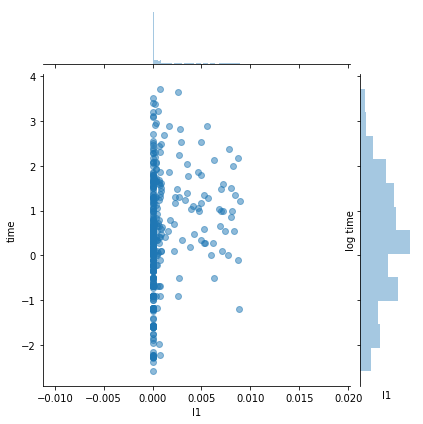

In [8]:
plt.figure(figsize = (6, 3))
sns.jointplot(df_train.l1, df_train.time, alpha = 0.5)
plt.xlabel('l1')
plt.ylabel('log time')
plt.show()

/Users/brian/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x216 with 0 Axes>

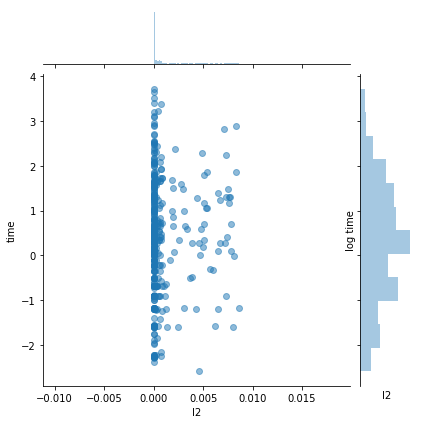

In [9]:
plt.figure(figsize = (6, 3))
sns.jointplot(df_train.l2, df_train.time, alpha = 0.5)
plt.xlabel('l2')
plt.ylabel('log time')
plt.show()

/Users/brian/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x216 with 0 Axes>

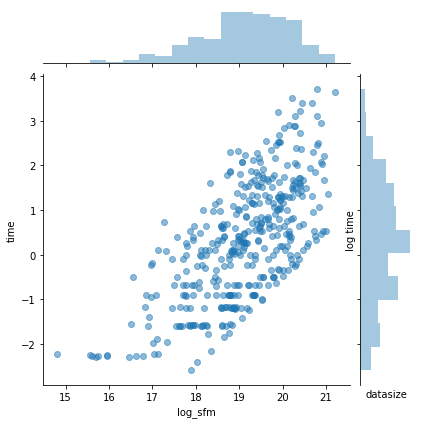

In [10]:
plt.figure(figsize = (6, 3))
sns.jointplot(df_train.log_sfm, df_train.time, alpha = 0.5)
plt.xlabel('datasize')
plt.ylabel('log time')
plt.show()

/Users/brian/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x216 with 0 Axes>

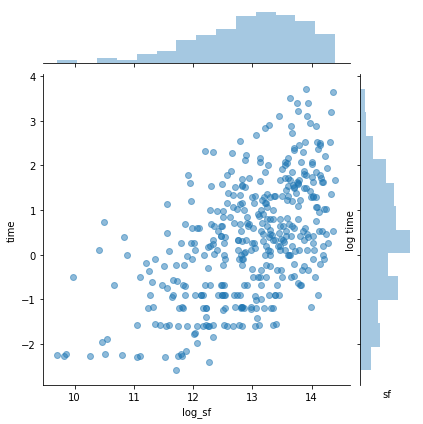

In [11]:
plt.figure(figsize = (6, 3))
sns.jointplot(df_train.log_sf, df_train.time, alpha = 0.5)
plt.xlabel('sf')
plt.ylabel('log time')
plt.show()

/Users/brian/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x216 with 0 Axes>

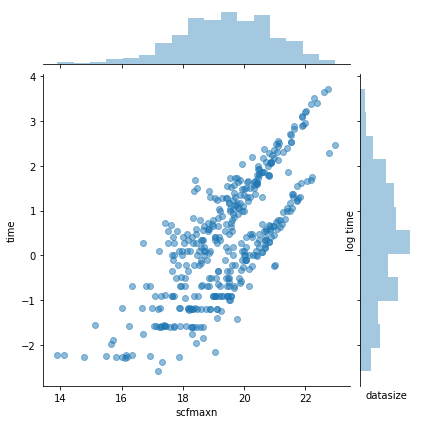

In [12]:
plt.figure(figsize = (6, 3))
sns.jointplot(df_train.scfmaxn, df_train.time, alpha = 0.5)
plt.xlabel('datasize')
plt.ylabel('log time')
plt.show()

/Users/brian/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x216 with 0 Axes>

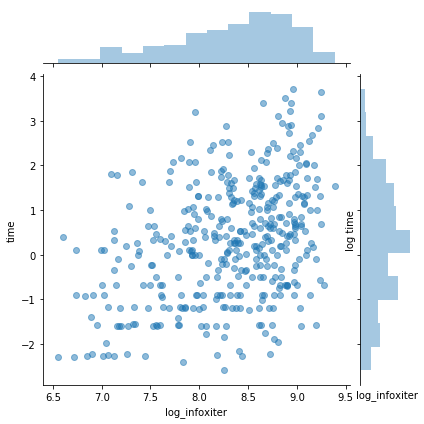

In [13]:
plt.figure(figsize = (6, 3))
sns.jointplot(df_train.log_infoxiter, df_train.time, alpha = 0.5)
plt.xlabel('log_infoxiter')
plt.ylabel('log time')
plt.show()

/Users/brian/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x216 with 0 Axes>

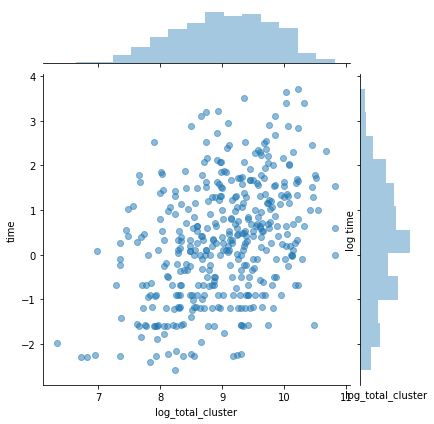

In [14]:
plt.figure(figsize = (6, 3))
sns.jointplot(df_train.log_total_cluster, df_train.time, alpha = 0.5)
plt.xlabel('log_total_cluster')
plt.ylabel('log time')
plt.show()

/Users/brian/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x216 with 0 Axes>

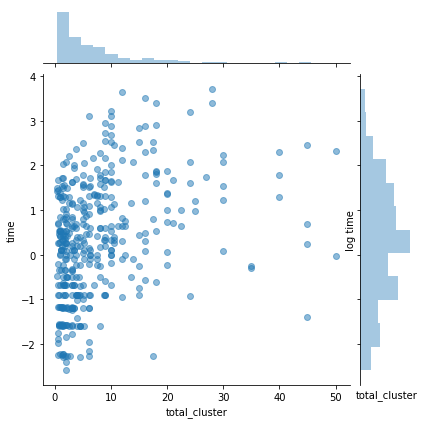

In [15]:
plt.figure(figsize = (6, 3))
sns.jointplot(df_train.total_cluster, df_train.time, alpha = 0.5)
plt.xlabel('total_cluster')
plt.ylabel('log time')
plt.show()

In [16]:
Y = df_train.filter(items=['time']).values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=7)

In [17]:
BestCVmodel = []
SelectedModel = None
SelectedModel_Name = None
SelectedModel_Score = None
ctr = 0
my_Regressor = [xgb.XGBRegressor]
for current_selected_model in my_Regressor:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    current_model = current_selected_model()
    current_model.fit(X_train, Y_train.ravel())
    results = model_selection.cross_val_score(current_model, X_train, Y_train.ravel(), cv=kfold, scoring='neg_mean_squared_error')
    means = abs(results.mean())
    BestCVmodel.append(current_model)
    BestCVmodel.append(means)

In [18]:
totalsum = 0
dict_result ={}
i = 0
for j in range(1000):
    my_model = BestCVmodel[0]
    my_model.fit(X, Y.ravel())
    my_logYPred = my_model.predict(X_t)
    my_YPred = np.power(np.e, my_logYPred)
    totalsum += BestCVmodel[1]
    dict_result[i] = my_YPred
    i += 1

In [19]:
my_Pred = []
for key, value in dict_result.items():
    temp = BestCVmodel[1]/totalsum*value
    if len(my_Pred) == 0:
        my_Pred = temp
    else:
        my_Pred = [my_Pred[i]+temp[i] for i in range(len(my_Pred))]

In [22]:
my_Pred = np.around(my_Pred, decimals=2)

In [23]:
df_Submission = pd.DataFrame({'Id': range(100),'time': my_Pred})
df_Submission = df_Submission.set_index('Id')

In [24]:
df_Submission

,time
Id,
0,1.630000
1,8.440000
2,0.440000
3,1.070000
4,2.250000
5,8.420000
6,2.920000
7,0.640000
8,11.640000


In [ ]:
#df_Submission.to_csv("bslam_27.csv")